In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [10]:
import pickle
import glob
import json
from tqdm import trange, tqdm
import numpy as np
import pandas as pd
import tikzplotlib
import matplotlib.pyplot as plt
import shap
shap.initjs()
from sklearn.metrics import roc_curve, auc
from features import merge_entries, prepare_entry
from utills import chunker, cartesian_product
import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA_DIR = '../data/pan/'
GROUND_TRUTH_PATH = DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'
DATA_PATH = DATA_DIR + 'pan20-authorship-verification-training-large.jsonl'
PREPROCESSED_DATA_PATH = '../temp_data/pan/'
# TEMP_DATA_PATH = '../temp_data/pan/'
FIGURES_PATH = '../figures/'
COMPUTED_DATA_PATH = '../temp_data/gpt3/'

In [5]:
with open(PREPROCESSED_DATA_PATH + 'experiment_data.p', 'rb') as f:
    (
        aucs,
        clf,
        roc_auc,
        transformer, 
        scaler,
        secondary_scaler,
        feature_sz,
        train_sz,
        train_idxs,
        test_sz,
        test_idxs
    ) = pickle.load(f)
    
fnames = np.array(transformer.get_feature_names())
XX_train = np.memmap(PREPROCESSED_DATA_PATH + 'vectorized_XX_train.npy', dtype='float32', mode='r', shape=(train_sz, feature_sz))
XX_test = np.memmap(PREPROCESSED_DATA_PATH + 'vectorized_XX_test.npy', dtype='float32', mode='r', shape=(test_sz, feature_sz))
XX_train_sampled = XX_train[np.random.choice(train_sz, 5000), :]
XX_test_sampled = XX_test[np.random.choice(test_sz, 5000), :]

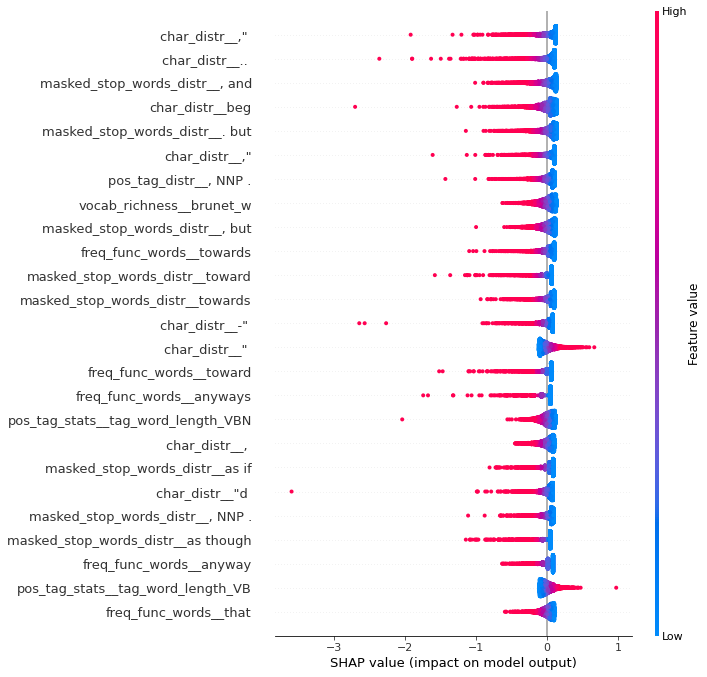

<Figure size 432x288 with 0 Axes>

In [6]:
explainer = shap.LinearExplainer(clf, XX_train_sampled)
shap_values = explainer.shap_values(XX_test_sampled)
plt.clf()
shap.summary_plot(shap_values, XX_test_sampled, feature_names=transformer.get_feature_names(), max_display=25)
plt.tight_layout()

In [7]:
def predict_pan(docs_1, docs_2, clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan):
    docs_merged_1 = [merge_entries(c) for c in docs_1]
    docs_merged_2 = [merge_entries(c) for c in docs_2]
    
    X_1 = scaler_pan.transform(transformer_pan.transform(docs_merged_1).todense())
    X_2 = scaler_pan.transform(transformer_pan.transform(docs_merged_2).todense())
    
    p = clf_pan.predict_proba(secondary_scaler_pan.transform(np.abs(X_1 - X_2)))[:, 1]
    return p

# HUMAN-GPT3

In [8]:
def fix_quotes(e):
    text = e['preprocessed'].replace('\'', '"')
    return prepare_entry(text, mode='accurate', tokenizer='casual')

In [11]:
human_docs_1 = []
human_docs_2 = []
ai_docs_1 = []
ai_docs_2 = []

pair_ids = []
for fname in glob.glob(COMPUTED_DATA_PATH + 'human_gpt3_preprocessed.jsonl'):
    with open(fname, 'r') as f:
        for l in f:
            d = json.loads(l)
            human_docs_1.append(list(map(fix_quotes, d['pair'][0]['human'])))
            human_docs_2.append(list(map(fix_quotes, d['pair'][1]['human'])))
            
            ai_docs_1.append(list(map(fix_quotes, d['pair'][0]['ai'])))
            ai_docs_2.append(list(map(fix_quotes, d['pair'][1]['ai'])))
            pair_ids.append(d['id'])
print('Read:', len(human_docs_1))

Read: 93


In [11]:
GROUND_TRUTH_PATH = '../data/pan/pan20-authorship-verification-training-large-truth.jsonl'
ground_truth = {}
with open(GROUND_TRUTH_PATH, 'r') as f:
    for l in f:
        d = json.loads(l)
        ground_truth[d['id']] = d['same']
        
test_docs_1 = []
test_docs_2 = []
labels = []
with open('../temp_data/pan/preprocessed_test.jsonl', 'r') as f:
    for l in f:
#         if np.random.rand() > 0.005:
#             continue
        d = json.loads(l)
        if d['id'] not in pair_ids:
            continue

        test_docs_1.append(d['pair'][0])
        test_docs_2.append(d['pair'][1])
        labels.append(ground_truth[d['id']])
        if len(test_docs_1) == len(pair_ids):
            break
            
print('Read:', len(human_docs_1))

Read: 93


In [12]:
probs_hh = predict_pan(
    human_docs_1, human_docs_2,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = human_docs_1
docs_2 = human_docs_2

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_hh = explainer.shap_values(X_diff)


probs_aa = predict_pan(
    ai_docs_1, ai_docs_2,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = ai_docs_1
docs_2 = ai_docs_2

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_aa = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_aa = explainer.shap_values(X_diff_aa)

probs_ha1 = predict_pan(
    human_docs_1, ai_docs_1,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = human_docs_1
docs_2 = ai_docs_1

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_ha1 = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_ha1 = explainer.shap_values(X_diff_ha1)

In [13]:
shap_summaries_df = pd.DataFrame(
    data=np.vstack([
        np.abs(shap_values.mean(axis=0)),
        np.abs(shap_values_hh.mean(axis=0)), 
        np.abs(shap_values_aa.mean(axis=0)),
        np.abs(shap_values_ha1.mean(axis=0))
        
    ]).T,
    columns=['overall', 'human-human', 'gpt3-gpt3', 'human-gpt3'])
shap_summaries_df['fnames'] = fnames

# Human - ChatGPT

In [14]:
human_docs_1 = []
human_docs_2 = []
ai_docs_1 = []
ai_docs_2 = []

pair_ids = []
for fname in glob.glob(COMPUTED_DATA_PATH + 'human_chatgpt_preprocessed.jsonl'):
    with open(fname, 'r') as f:
        for l in f:
            d = json.loads(l)
            human_docs_1.append(list(map(fix_quotes, d['pair'][0]['human'])))
            human_docs_2.append(list(map(fix_quotes, d['pair'][1]['human'])))
            
            ai_docs_1.append(list(map(fix_quotes, d['pair'][0]['ai'])))
            ai_docs_2.append(list(map(fix_quotes, d['pair'][1]['ai'])))
            pair_ids.append(d['id'])
print('Read:', len(human_docs_1))

Read: 48


In [16]:

probs_aa = predict_pan(
    ai_docs_1, ai_docs_2,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = ai_docs_1
docs_2 = ai_docs_2

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_aa = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_aa = explainer.shap_values(X_diff_aa)

probs_ha1 = predict_pan(
    human_docs_1, ai_docs_1,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = human_docs_1
docs_2 = ai_docs_1

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_ha1 = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_ha1 = explainer.shap_values(X_diff_ha1)


shap_summaries_df['chatgpt-chatgpt'] = np.abs(shap_values_aa.mean(axis=0))
shap_summaries_df['human-chatgpt'] = np.abs(shap_values_ha1.mean(axis=0))


# Human - GPT2

In [20]:
human_docs_1 = []
human_docs_2 = []
ai_docs_1 = []
ai_docs_2 = []

pair_ids = []
for fname in glob.glob('../temp_data/ai/human_ai_preprocessed*.jsonl'):
    with open(fname, 'r') as f:
        for l in f:
            d = json.loads(l)
            human_docs_1.append(list(map(fix_quotes, d['pair'][0]['human'])))
            human_docs_2.append(list(map(fix_quotes, d['pair'][1]['human'])))
            
            ai_docs_1.append(list(map(fix_quotes, d['pair'][0]['ai'])))
            ai_docs_2.append(list(map(fix_quotes, d['pair'][1]['ai'])))
            pair_ids.append(d['id'])
print('Read:', len(human_docs_1))

Read: 97


In [22]:

probs_aa = predict_pan(
    ai_docs_1, ai_docs_2,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = ai_docs_1
docs_2 = ai_docs_2

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_aa = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_aa = explainer.shap_values(X_diff_aa)

probs_ha1 = predict_pan(
    human_docs_1, ai_docs_1,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = human_docs_1
docs_2 = ai_docs_1

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_ha1 = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_ha1 = explainer.shap_values(X_diff_ha1)


shap_summaries_df['gpt2-gpt2'] = np.abs(shap_values_aa.mean(axis=0))
shap_summaries_df['human-gpt2'] = np.abs(shap_values_ha1.mean(axis=0))


In [23]:
shap_summaries_df

,overall,human-human,gpt3-gpt3,human-gpt3,fnames,chatgpt-chatgpt,human-chatgpt,gpt2-gpt2,human-gpt2
0,0.000051,0.000360,0.000575,0.000351,char_distr__,0.000464,0.000582,0.000727,0.000860
1,0.001218,0.004521,0.024053,0.014236,"char_distr__ """,0.015171,0.004805,0.029190,0.028642
2,0.000700,0.006153,0.007579,0.006887,"char_distr__ """,0.007372,0.007372,0.007074,0.006794
3,0.000238,0.002025,0.004922,0.002284,"char_distr__ "".",0.004922,0.000561,0.001646,0.001239
4,0.000059,0.000659,0.007311,0.002005,"char_distr__ ""a",0.003423,0.002306,0.008542,0.003328
...,...,...,...,...,...,...,...,...,...
22154,0.000043,0.000825,0.000268,0.000759,pos_tag_stats__tag_word_length_VBZ,0.001056,0.000899,0.000182,0.001067
22155,0.000332,0.001445,0.001024,0.001882,pos_tag_stats__tag_word_length_WDT,0.001993,0.000879,0.014591,0.003853
22156,0.000060,0.001117,0.002205,0.001496,pos_tag_stats__tag_word_length_WP,0.002391,0.000639,0.003170,0.000784
22157,0.000704,0.015170,0.019901,0.017535,pos_tag_stats__tag_word_length_WP$,0.010807,0.015391,0.014328,0.014328


In [24]:
shap_summaries_df.to_csv('shap_summaries_new.csv')

-0.41666666666666663
-0.24999999999999997
-0.08333333333333331
0.08333333333333337
0.25


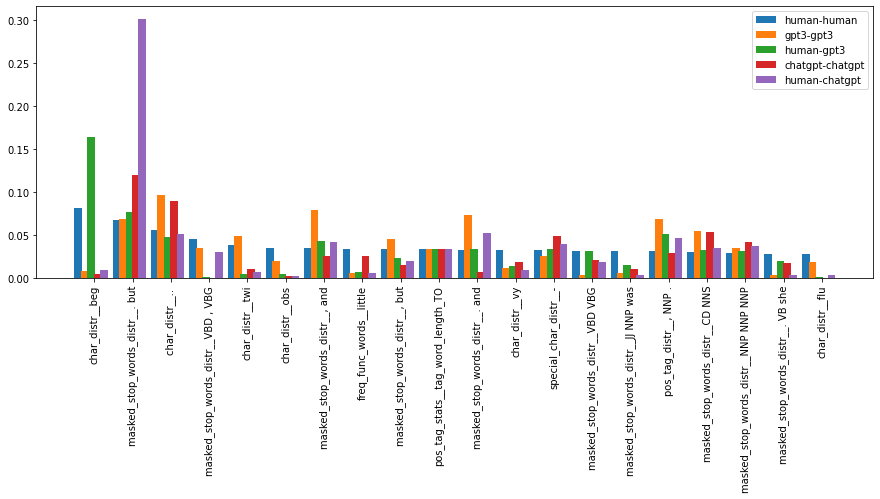

In [25]:
shap_summaries_selected_df = shap_summaries_df.sort_values('human-human', ascending=False).head(20)
x = np.arange(len(shap_summaries_selected_df))
fig, ax = plt.subplots( figsize=(15, 5))
cols = ['human-human', 'gpt3-gpt3', 'human-gpt3', 'chatgpt-chatgpt', 'human-chatgpt']
for i, c in enumerate(cols):
    width = 1/(len(cols)+1)
    offset = width * i - (width*len(cols)/2)
    print(offset)
    ax.bar(x + offset, shap_summaries_selected_df[c], width=0.2, label=c)

    
ax.set_xticks(x)
ax.set_xticklabels(labels=shap_summaries_selected_df['fnames'], rotation=90)
ax.legend()
plt.show()

-0.3333333333333333
0.0


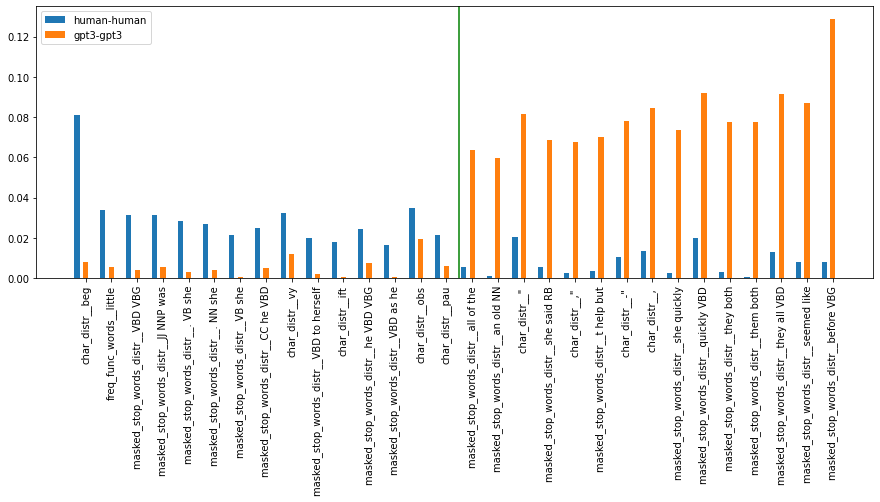

In [29]:
# shap_summaries_selected_df = shap_summaries_df.sort_values('gpt3-gpt3', ascending=False).head(20)
# shap_summaries_selected_df = shap_summaries_df.sort_values('chatgpt-chatgpt', ascending=False).head(20)
# shap_summaries_selected_df = shap_summaries_df.sort_values('human-human', ascending=False).head(20)
# shap_summaries_selected_df = shap_summaries_df.sort_values('overall', ascending=False).head(20)
# shap_summaries_df['all_importance'] = shap_summaries_df['human-human'] + shap_summaries_df['chatgpt-chatgpt'] + shap_summaries_df['gpt3-gpt3']
shap_summaries_df['importance_diff'] = (shap_summaries_df['human-human'] - shap_summaries_df['gpt3-gpt3'])
shap_summaries_selected_df = pd.concat([
    shap_summaries_df.sort_values('importance_diff', ascending=False).head(15),
    shap_summaries_df.sort_values('importance_diff', ascending=False).tail(15)
])
x = np.arange(len(shap_summaries_selected_df))
fig, ax = plt.subplots( figsize=(15, 5))
# cols = ['human-human', 'gpt3-gpt3', 'human-gpt3', 'chatgpt-chatgpt', 'human-chatgpt']
cols = ['human-human', 'gpt3-gpt3']
# c_1 = 'human-human'
for i, c in enumerate(cols):
    width = 1/(len(cols)+1)
    offset = width * i - (width*len(cols)/2)
    print(offset)
    ax.bar(x + offset, shap_summaries_selected_df[c], width=0.2, label=c)

plt.axvline(x=14.5, color='green')
ax.set_xticks(x)
ax.set_xticklabels(labels=shap_summaries_selected_df['fnames'], rotation=90)
ax.legend()
plt.show()

In [27]:
width

0.16666666666666666